In [30]:
# Import modules
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import utils.data_preprocessor as dp
from importlib import reload
from sklearn.preprocessing import StandardScaler
import utils.data_wrangling as wr
import utils.data_transformation as tr
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import utils.lasso_regression as lr
import utils.gradient_boost_regression as gb
import utils.LSTM as lstm
import utils.eda_visuals as viz
from sklearn.linear_model import Ridge
import utils.model_training as mlt
import utils.standardization_and_pca as spca
import utils.prophet as pht
# add reload to ensure we have latest working version in cache
modules = [mlt, dp, wr, tr, lr, gb, lstm, viz, spca, pht]
for module in modules:
    reload(module)



In [5]:

# Reading in the csv files
stock_data = dp.read_data('data/stock_data.csv')
unemployment = dp.read_data('data/SeriesReport.csv')

In [6]:
# Print list of missing values per column and preview of df
dp.print_missing(stock_data)
stock_data.head()

dt has 0 missing values
vix has 0 missing values
sp500 has 0 missing values
sp500_volume has 0 missing values
djia has 0 missing values
djia_volume has 0 missing values
hsi has 0 missing values
ads has 0 missing values
us3m has 0 missing values
joblessness has 0 missing values
epu has 0 missing values
GPRD has 0 missing values
prev_day has 0 missing values


,dt,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD,prev_day
0,1990-01-03,18.19,358.760010,192330000.0,2809.73,23.62,2858.699951,-0.229917,7.89,3,100.359178,75.408051,359.690002
1,1990-01-04,19.22,355.670013,177000000.0,2796.08,24.37,2868.000000,-0.246065,7.84,3,100.359178,56.085804,358.760010
2,1990-01-05,20.11,352.200012,158530000.0,2773.25,20.29,2839.899902,-0.260393,7.79,3,100.359178,63.847675,355.670013
3,1990-01-08,20.26,353.790009,140110000.0,2794.37,16.61,2816.000000,-0.291750,7.79,3,100.359178,102.841156,352.200012
4,1990-01-09,22.20,349.619995,155210000.0,2766.00,15.80,2822.000000,-0.297326,7.80,3,100.359178,138.435669,353.790009


In [7]:
# Print list of missing values per column and preview of df
dp.print_missing(unemployment)
unemployment.head()

Year has 0 missing values
Jan has 0 missing values
Feb has 0 missing values
Mar has 0 missing values
Apr has 0 missing values
May has 0 missing values
Jun has 0 missing values
Jul has 0 missing values
Aug has 0 missing values
Sep has 0 missing values
Oct has 0 missing values
Nov has 0 missing values
Dec has 0 missing values


,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1990,5.4,5.3,5.2,5.4,5.4,5.2,5.5,5.7,5.9,5.9,6.2,6.3
1,1991,6.4,6.6,6.8,6.7,6.9,6.9,6.8,6.9,6.9,7.0,7.0,7.3
2,1992,7.3,7.4,7.4,7.4,7.6,7.8,7.7,7.6,7.6,7.3,7.4,7.4
3,1993,7.3,7.1,7.0,7.1,7.1,7.0,6.9,6.8,6.7,6.8,6.6,6.5
4,1994,6.6,6.6,6.5,6.4,6.1,6.1,6.1,6.0,5.9,5.8,5.6,5.5


## Exploratory Data Analysis

In [8]:
stock_data = wr.date_transform(stock_data, 'dt')

unemployment_unpivot = wr.unpivot_df(unemployment)

unemployment_unpivot_mapping = wr.mapping_month_names(unemployment_unpivot, 'Month')

stock_data_final = wr.merge_dfs(stock_data, unemployment_unpivot)

# Returning the First Five Records
stock_data_final.head()


,dt,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD,prev_day,Year,Month,Unemployment Percent
0,1990-01-03,18.19,358.760010,192330000.0,2809.73,23.62,2858.699951,-0.229917,7.89,3,100.359178,75.408051,359.690002,1990,1,5.4
1,1990-01-04,19.22,355.670013,177000000.0,2796.08,24.37,2868.000000,-0.246065,7.84,3,100.359178,56.085804,358.760010,1990,1,5.4
2,1990-01-05,20.11,352.200012,158530000.0,2773.25,20.29,2839.899902,-0.260393,7.79,3,100.359178,63.847675,355.670013,1990,1,5.4
3,1990-01-08,20.26,353.790009,140110000.0,2794.37,16.61,2816.000000,-0.291750,7.79,3,100.359178,102.841156,352.200012,1990,1,5.4
4,1990-01-09,22.20,349.619995,155210000.0,2766.00,15.80,2822.000000,-0.297326,7.80,3,100.359178,138.435669,353.790009,1990,1,5.4


In [9]:
# Returning Information on the DataFrame
stock_data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8597 entries, 0 to 8596
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   dt                    8597 non-null   datetime64[ns]
 1   vix                   8597 non-null   float64       
 2   sp500                 8597 non-null   float64       
 3   sp500_volume          8597 non-null   float64       
 4   djia                  8597 non-null   float64       
 5   djia_volume           8597 non-null   float64       
 6   hsi                   8597 non-null   float64       
 7   ads                   8597 non-null   float64       
 8   us3m                  8597 non-null   float64       
 9   joblessness           8597 non-null   int64         
 10  epu                   8597 non-null   float64       
 11  GPRD                  8597 non-null   float64       
 12  prev_day              8597 non-null   float64       
 13  Year              

In [10]:
# Returning Descriptive Statistics on the Data
stock_data_final.describe()

,dt,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD,prev_day,Year,Month,Unemployment Percent
count,8597,8597.000000,8597.000000,8.597000e+03,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000
mean,2007-01-19 10:42:31.866930432,19.560306,1596.652238,2.463780e+09,13662.535273,183.166216,16763.460949,-0.158047,2.690266,2.492381,115.564631,109.435667,1596.111831,2006.551704,6.521345,5.758160
min,1990-01-03 00:00:00,9.140000,295.459991,1.499000e+07,2365.100000,1.590000,2736.600098,-26.418300,0.000000,1.000000,57.202620,9.491598,295.459991,1990.000000,1.000000,3.400000
25%,1998-07-06 00:00:00,13.850000,898.700012,6.467400e+08,8038.570000,63.720000,10722.799805,-0.383563,0.180000,1.000000,85.925868,72.857056,897.989990,1998.000000,4.000000,4.500000
50%,2007-01-22 00:00:00,17.730000,1270.199951,2.521000e+09,10846.290000,177.830000,16803.759766,-0.045977,2.300000,2.000000,106.115769,96.603577,1270.089966,2007.000000,7.000000,5.400000
75%,2015-08-04 00:00:00,22.960000,2058.899902,3.834320e+09,17635.390000,272.590000,22867.330078,0.247940,4.990000,3.000000,137.077404,129.159744,2058.689941,2015.000000,10.000000,6.700000
max,2024-02-16 00:00:00,82.690000,5029.730000,1.145623e+10,38797.900000,922.680000,33154.121094,9.482140,8.260000,4.000000,350.459817,1045.603638,5029.730000,2024.000000,12.000000,14.800000
std,NaN,7.902780,1106.241259,1.847305e+09,9022.864862,133.671305,7350.096474,1.651492,2.296294,1.117501,41.579530,64.568210,1105.710429,9.855177,3.437762,1.748314


In [11]:
# Extracting the Desired Columns
stock_data_sample = stock_data_final[['vix', 'us3m', 'epu', 'GPRD', 'Unemployment Percent']]

# Creating the Columns Variable for the for loop
columns_to_plot = stock_data_sample.columns

# Creating a Dictionary to Map the Variable Names to
column_name_mapping = {
    'vix': 'Volatility Index (VIX)',
    'us3m': 'U.S. Treasury 3-Month Bond Yield',
    'epu': 'Economic Policy Uncertainty Index',
    'GPRD': 'Geopolitical Risk Index',
    'Unemployment Percent': 'Unemployment Percent'
}

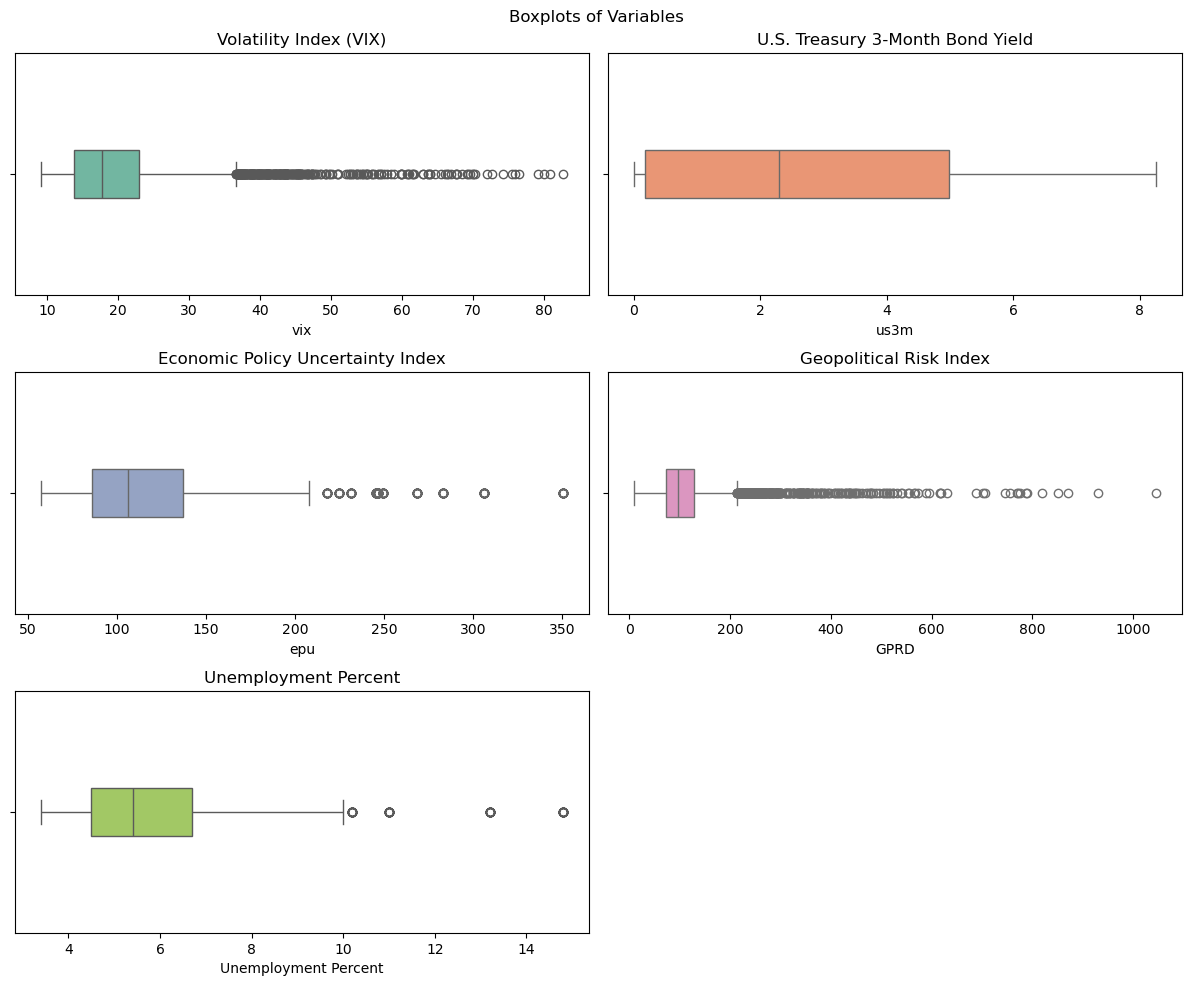

In [12]:
viz.boxplot_visuals(stock_data_sample, columns_to_plot, column_name_mapping, 'Boxplots of Variables')

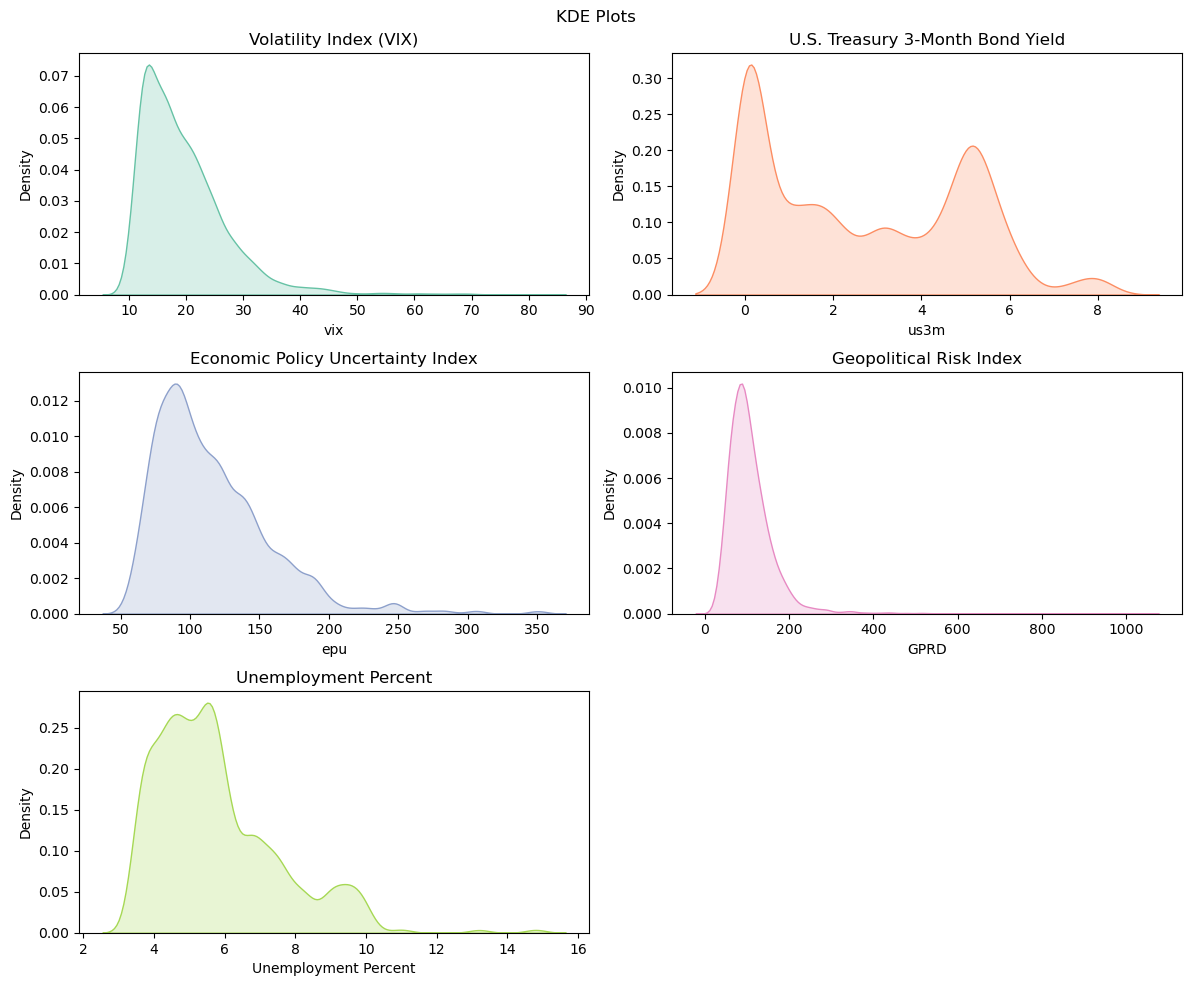

In [13]:
viz.kde_visuals(stock_data_sample, columns_to_plot, column_name_mapping, 'KDE Plots')

<Figure size 800x600 with 0 Axes>

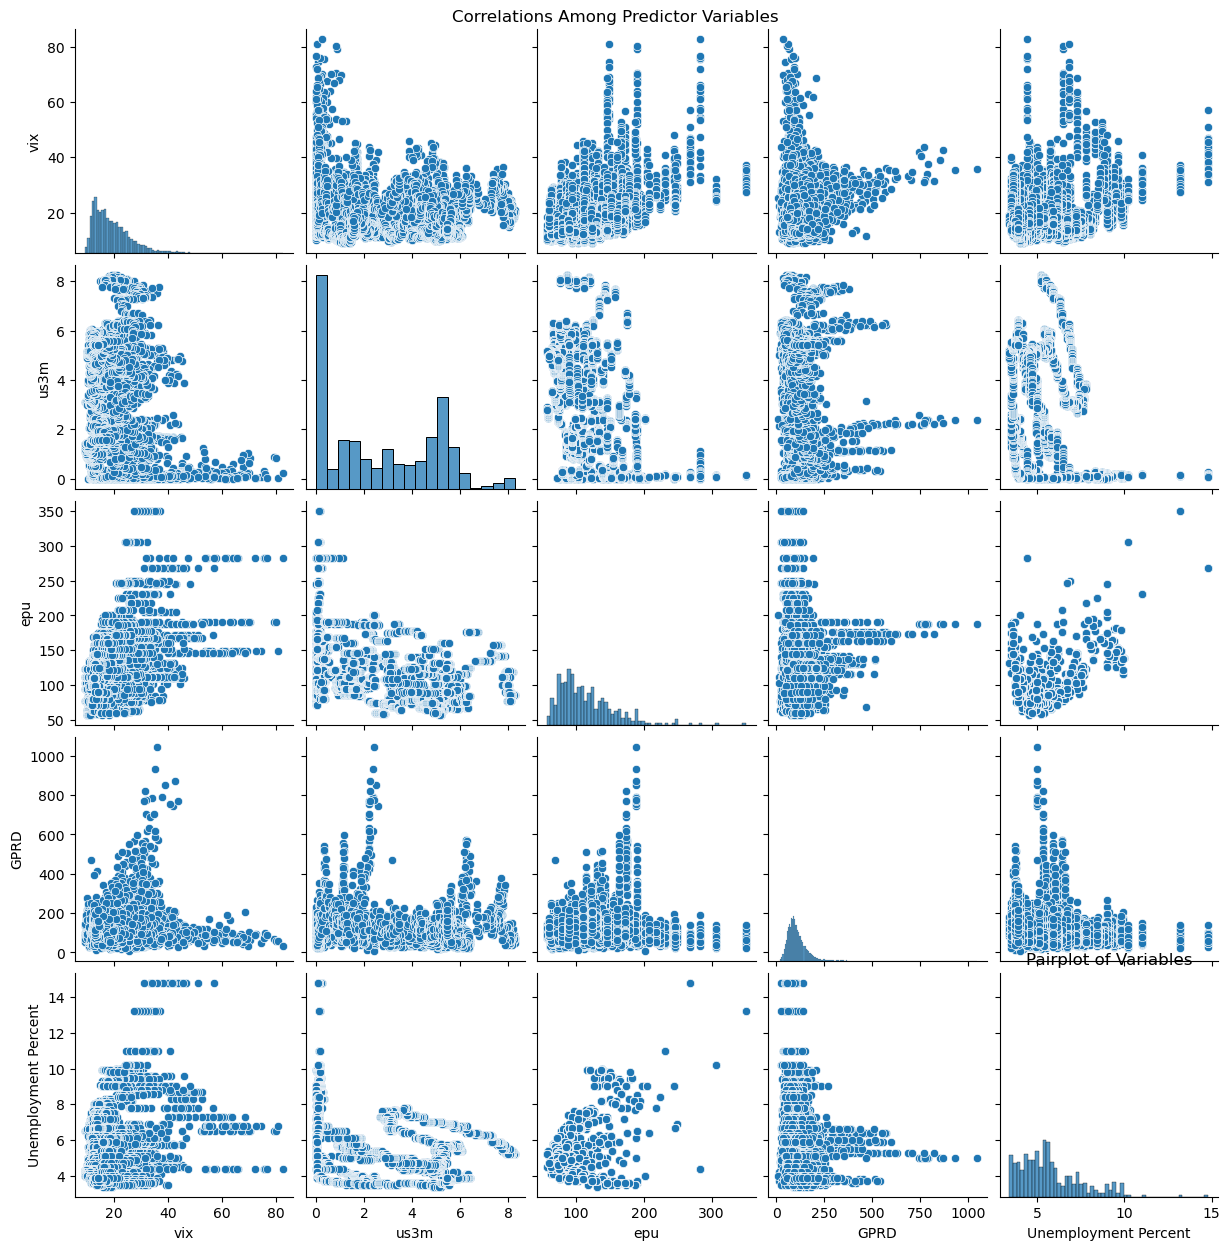

In [14]:
viz.pairplot_visual(stock_data_sample, 'Pairplot of Variables')

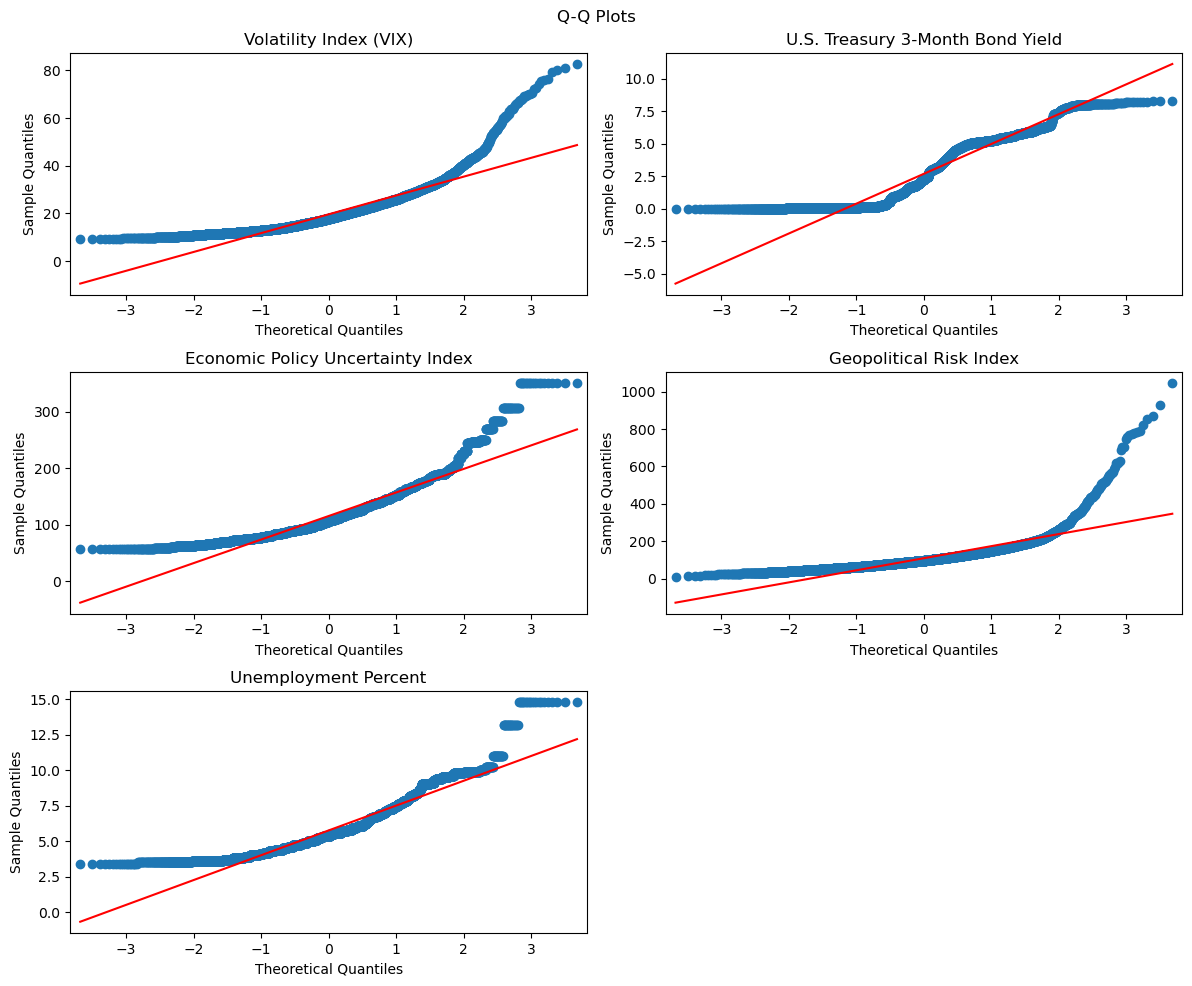

In [15]:
viz.qq_plot(stock_data_sample, columns_to_plot, column_name_mapping, 'Q-Q Plots')

### Performing Log Transfomartions

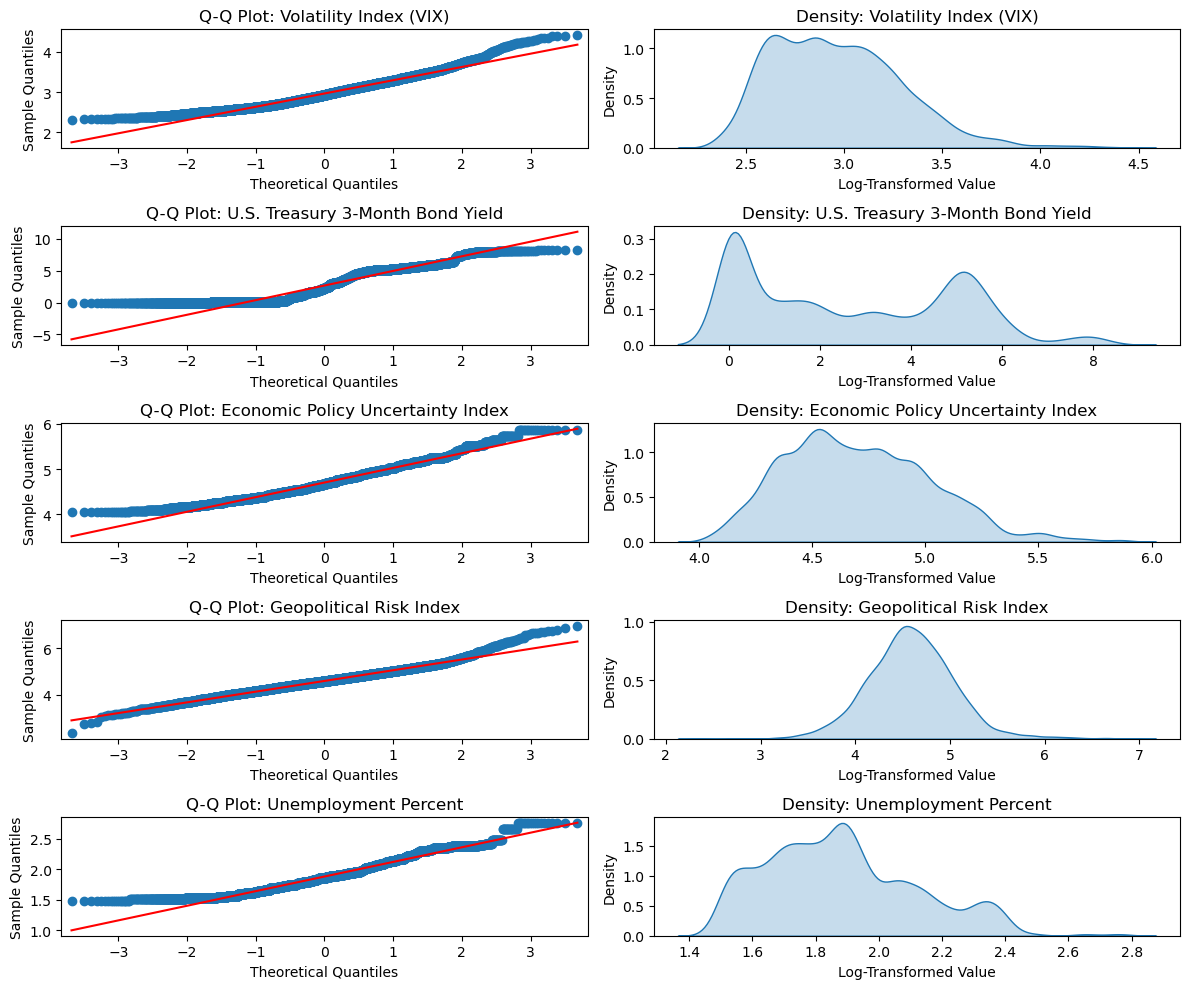

In [16]:
stock_data_final = tr.log_transform(stock_data_final, columns = ['vix', 'us3m', 'epu', 'GPRD', 'Unemployment Percent'])

In [17]:

# Initializing a List of Numerical Columns
numeric_columns = stock_data_final.select_dtypes(include = 'number').columns

# Dropping the Response Variable from Standardization
numeric_columns = numeric_columns.drop('vix')

# Setting the Date as the Index
# stock_data_final = stock_data_final.set_index('dt', inplace = True)

# Initializing a Variable to Standardize the Numeric Features
scaler = StandardScaler()

# Standardizing the Numeric Features
stock_data_final[numeric_columns] = scaler.fit_transform(stock_data_final[numeric_columns])

# Dropping the Year and Month Columns
stock_data_final = stock_data_final.drop(columns = ['Year', 'Month'])

# Confirming that the features were standardized
stock_data_final.head()


,dt,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD,prev_day,Unemployment Percent
0,1990-01-03,2.954389,-1.119073,-1.229674,-1.202881,-1.193641,-1.891889,-0.043521,2.264534,0.454271,-0.264655,-0.556686,-1.118280,-0.101939
1,1990-01-04,3.006672,-1.121866,-1.237973,-1.204394,-1.188029,-1.890624,-0.053299,2.242758,0.454271,-0.264655,-1.193000,-1.119121,-0.101939
2,1990-01-05,3.049747,-1.125003,-1.247972,-1.206925,-1.218554,-1.894447,-0.061975,2.220983,0.454271,-0.264655,-0.914744,-1.121916,-0.101939
3,1990-01-08,3.056827,-1.123566,-1.257943,-1.204584,-1.246086,-1.897699,-0.080964,2.220983,0.454271,-0.264655,0.112896,-1.125054,-0.101939
4,1990-01-09,3.144152,-1.127335,-1.249769,-1.207728,-1.252146,-1.896883,-0.084340,2.225338,0.454271,-0.264655,0.756213,-1.123616,-0.101939


In [18]:
# Standardizing all variables in a copy, so we can reasign no scaled values as we need them

stock_scaler = StandardScaler()
scaled_stock_data = stock_scaler.fit_transform(stock_data_final.select_dtypes(include='number'))
scaled_stock_data_df = pd.DataFrame(
    scaled_stock_data, 
    columns=stock_data_final.select_dtypes(include='number').columns)
scaled_stock_data_df


,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD,prev_day,Unemployment Percent
0,-0.030528,-1.119073,-1.229674,-1.202881,-1.193641,-1.891889,-0.043521,2.264534,0.454271,-0.264655,-0.556686,-1.118280,-0.101939
1,0.127802,-1.121866,-1.237973,-1.204394,-1.188029,-1.890624,-0.053299,2.242758,0.454271,-0.264655,-1.193000,-1.119121,-0.101939
2,0.258246,-1.125003,-1.247972,-1.206925,-1.218554,-1.894447,-0.061975,2.220983,0.454271,-0.264655,-0.914744,-1.121916,-0.101939
3,0.279688,-1.123566,-1.257943,-1.204584,-1.246086,-1.897699,-0.080964,2.220983,0.454271,-0.264655,0.112896,-1.125054,-0.101939
4,0.544136,-1.127335,-1.249769,-1.207728,-1.252146,-1.896883,-0.084340,2.225338,0.454271,-0.264655,0.756213,-1.123616,-0.101939
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8592,-0.790687,3.096419,0.726484,2.785903,0.579768,-0.138357,0.039769,1.193180,-1.335541,-0.626268,1.025205,3.102709,-1.215826
8593,-0.424327,3.034341,0.995243,2.727669,0.917481,-0.138357,0.052629,1.201891,-1.335541,-0.626268,1.418415,3.098395,-1.215826
8594,-0.700760,3.077236,0.748063,2.744426,0.618971,-0.120289,0.063919,1.193180,-1.335541,-0.626268,0.714710,3.036286,-1.215826
8595,-0.774504,3.103552,0.906340,2.783157,0.876707,-0.111411,0.073641,1.193180,-1.335541,-0.626268,1.709566,3.079202,-1.215826


In [19]:
# Standardizing all variables in a copy, so we can reasign no scaled values as we need them

unemployment_scaler = StandardScaler()
scaled_unemployment_data = unemployment_scaler.fit_transform(
    unemployment.select_dtypes(include='number')
    )
scaled_unemployment_data_df = pd.DataFrame(
    scaled_unemployment_data, 
    columns=unemployment.select_dtypes(include='number').columns)
scaled_unemployment_data_df


,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,-1.683251,-0.151699,-0.205196,-0.272221,-0.240903,-0.229759,-0.339189,-0.160600,-0.010384,0.139052,0.164844,0.353397,0.421251
1,-1.584236,0.480381,0.613788,0.730700,0.345252,0.501293,0.586579,0.577513,0.716499,0.747402,0.847265,0.845691,1.038147
2,-1.485221,1.049253,1.117778,1.106795,0.660874,0.842450,1.076691,1.088514,1.140514,1.173248,1.033379,1.091839,1.099837
3,-1.386207,1.049253,0.928782,0.856065,0.525607,0.598766,0.641036,0.634291,0.655925,0.625732,0.723188,0.599544,0.544631
4,-1.287192,0.606797,0.613788,0.542652,0.209985,0.111398,0.150923,0.180067,0.171337,0.139052,0.102806,-0.015824,-0.072265
5,-1.188177,-0.025283,-0.142197,-0.146856,-0.060548,-0.132286,-0.121361,-0.047045,-0.010384,-0.043454,-0.083308,-0.015824,-0.010575
6,-1.089162,-0.025283,-0.079198,-0.084174,-0.150726,-0.132286,-0.284732,-0.160600,-0.373826,-0.286794,-0.269423,-0.138897,-0.133954
7,-0.990148,-0.214907,-0.268195,-0.272221,-0.376170,-0.473443,-0.448103,-0.501268,-0.555546,-0.469299,-0.579614,-0.631192,-0.565781
8,-0.891133,-0.657363,-0.646187,-0.585634,-0.736881,-0.717127,-0.720387,-0.728380,-0.737267,-0.651804,-0.703691,-0.754265,-0.750850
9,-0.792118,-0.846987,-0.772185,-0.899047,-0.736881,-0.814600,-0.829301,-0.841936,-0.918988,-0.895145,-0.951843,-0.938876,-0.997608


### Principal Component Analysis

In [46]:
'''
# Performing PCA on Numeric Features
# Creating a List of Numerical Columns
numeric_columns_pca = stock_data_final.select_dtypes(include='number')

# Separating out the X and y Variables
X = numeric_columns_pca.drop(columns = 'vix')
y = numeric_columns_pca['vix']

# Performing PCA
# Creating a Variable for PCA
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)
# Transforming all Variables
X_pca
'''

"\n# Performing PCA on Numeric Features\n# Creating a List of Numerical Columns\nnumeric_columns_pca = stock_data_final.select_dtypes(include='number')\n\n# Separating out the X and y Variables\nX = numeric_columns_pca.drop(columns = 'vix')\ny = numeric_columns_pca['vix']\n\n# Performing PCA\n# Creating a Variable for PCA\npca = PCA(n_components = 2)\nX_pca = pca.fit_transform(X)\n# Transforming all Variables\nX_pca\n"

In [47]:
'''
# Creating a DataFrame for the PCA Components
pca_df = pd.DataFrame(data = X_pca, columns = ['Principal Component 1', 'Principal Component 2'], index = stock_data_final.index)

# Concatenating the Original DataFrame with the PCA DataFrame
stock_data_merged = pd.concat([stock_data_final, pca_df], axis = 1)

# Returning the Top Five Rows
stock_data_merged.head()
'''

"\n# Creating a DataFrame for the PCA Components\npca_df = pd.DataFrame(data = X_pca, columns = ['Principal Component 1', 'Principal Component 2'], index = stock_data_final.index)\n\n# Concatenating the Original DataFrame with the PCA DataFrame\nstock_data_merged = pd.concat([stock_data_final, pca_df], axis = 1)\n\n# Returning the Top Five Rows\nstock_data_merged.head()\n"

In [20]:
stock_data_final_standardized = spca.standardize_data(stock_data_final, 'vix')

In [21]:
stock_data_final_pca = spca.pca_transformation(stock_data_final_standardized, 'vix', 2)

In [22]:
stock_data_final_pca.head()

,dt,Principal Component 1,Principal Component 2,vix
0,1990-01-03,-3.563771,-0.934551,2.954389
1,1990-01-04,-3.587543,-0.948208,3.006672
2,1990-01-05,-3.588825,-0.932276,3.049747
3,1990-01-08,-3.558739,-0.897608,3.056827
4,1990-01-09,-3.533960,-0.873479,3.144152


### Lasso Regression

In [51]:
# Dropping the Date Columns
stock_data_final_no_date = stock_data_final_standardized.drop(columns = ['dt'])

print('Original Lasso Regression Results:')
print(lr.lasso_regression(stock_data_final_no_date, 'vix', 1.0, 42),'\n')


print('Lasso Regression Results with Hyperparameter Tuning:')
print(lr.lasso_hyperparameter_tuning(stock_data_final_no_date, 'vix', 5, 100000, 42))

Original Lasso Regression Results:
Mean Squared Error: 0.10806197639498576
R-Squared: -0.00017192695750201104 

Lasso Regression Results with Hyperparameter Tuning:
Mean Squared Error: 0.054546603223945674
R-Squared: 0.495141741105417


/Users/emmagore/Desktop/GitHub/INFO-523-Notes/.conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.077e+01, tolerance: 7.516e-02
  model = cd_fast.enet_coordinate_descent(


### Gradient Boost Regression

In [52]:
# Dropping the Date Columns
stock_data_final_no_date_pca = stock_data_final_pca.drop(columns = ['dt'])

# Performing Gradient Boost with PCA Applied
print('Gradient Boost Regression Results with PCA Applied:\n')
print('Original Gradient Boost Regression Results:')
print(gb.gradient_boost(stock_data_final_no_date_pca, 'vix', 100, 42), '\n')

# Defining a Parameter Grid
param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }

# Performing Gradient Boost with PCA and Hyperparameter Tuning Applied
print('Gradient Boost Regression Results with Hyperparameter Tuning:')
print(gb.gradient_boost_hyperparameter_tuning(stock_data_final_no_date_pca, 'vix', param_grid, 5, 42))

Gradient Boost Regression Results with PCA Applied:

Original Gradient Boost Regression Results:
Mean Squared Error: 0.04727081423502597
R-Squared: 0.5624830959089338 

Gradient Boost Regression Results with Hyperparameter Tuning:
Mean Squared Error: 0.038911147446859716
R-Squared: 0.6398563248574916


In [53]:
# Performing Gradient Boost without PCA Applied
print('Gradient Boost Regression Results without PCA Applied:\n')
print('Original Gradient Boost Regression Results:')
print(gb.gradient_boost(stock_data_final_no_date, 'vix', 100, 42), '\n')

print('Gradient Boost Regression Results with Hyperparameter Tuning:')
print(gb.gradient_boost_hyperparameter_tuning(stock_data_final_no_date, 'vix', param_grid, 5, 42))

Gradient Boost Regression Results without PCA Applied:

Original Gradient Boost Regression Results:
Mean Squared Error: 0.01533574541828602
R-Squared: 0.8580593974121637 

Gradient Boost Regression Results with Hyperparameter Tuning:
Mean Squared Error: 0.004372265543798684
R-Squared: 0.9595323220988772


### Long Short-Term Memory (LSTM)

In [54]:
print(lstm.lstm_function(stock_data_final_no_date, 'vix'))

/Users/emmagore/Desktop/GitHub/INFO-523-Notes/.conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5483 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Squared Error: 2.442439196869365
R-Squared: -19.746618905900146


### Prophet

23:25:17 - cmdstanpy - INFO - Chain [1] start processing
23:25:20 - cmdstanpy - INFO - Chain [1] done processing


Figure(1000x600)


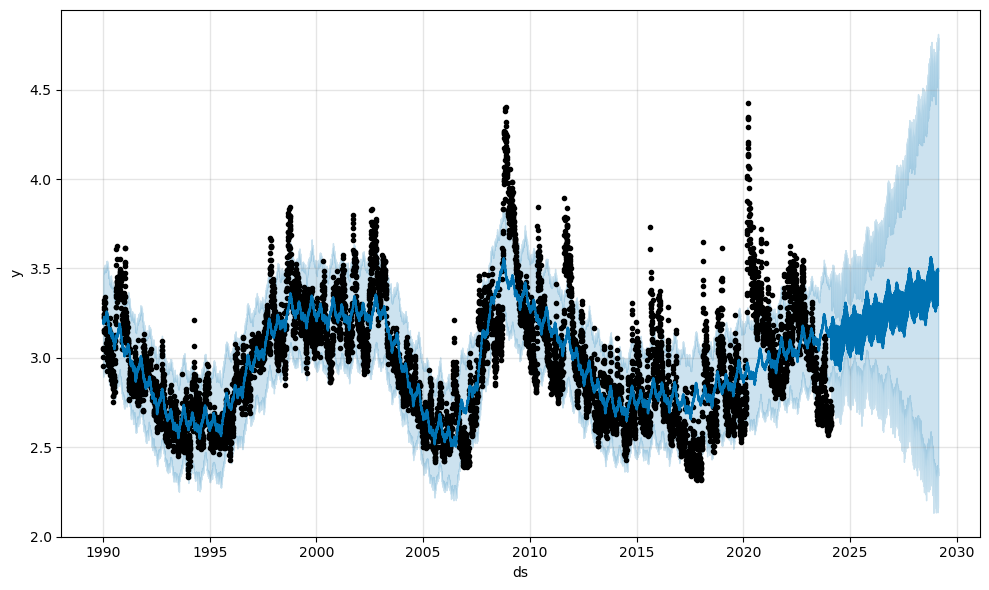

In [31]:
# Removing the Unnecessary Columns from the Analysis
stock_data_prophet = stock_data_final_standardized[['dt', 'vix']]

# Renaming the Columns
stock_data_prophet = stock_data_prophet.rename(columns = {'dt': 'ds', 'vix': 'y'})

print(pht.prophet_model(stock_data_prophet, 1827))

## Ridge

In [55]:
# split train/test data
y = stock_data['vix'].to_numpy()
jobless = scaled_stock_data_df['joblessness'].to_numpy().reshape(-1, 1)
us3m   = scaled_stock_data_df['us3m'].to_numpy().reshape(-1, 1)\
# one split on indices so everything stays aligned\n",
idx = np.arange(len(y))
idx_train, idx_test = train_test_split(
    idx,
    test_size=0.2,
    random_state=42,
    shuffle=True
)
# slice all arrays with the SAME indices
X_unemployment_train = jobless[idx_train]
X_unemployment_test  = jobless[idx_test]

X_bond_train = us3m[idx_train]
X_bond_test  = us3m[idx_test]
X_bond_jobless_train = np.hstack([X_unemployment_train, X_bond_train])
X_bond_jobless_test  = np.hstack([X_unemployment_test, X_bond_test])

y_train = y[idx_train]
y_test  = y[idx_test]

In [56]:
unemployment_ridge = Ridge()
bond_ridge = Ridge()
bond_unemployment_ridge = Ridge()
print(y_train)
batch_args = {
    unemployment_ridge: (X_unemployment_train, X_unemployment_test, 'Unemployment Ridge Model'),
    bond_ridge: (X_bond_train, X_bond_test, 'Bond Yield Ridge Model'),
    bond_unemployment_ridge : (X_bond_jobless_train, X_bond_jobless_test, 'Bond Yield Ridge & Unemployment Model')
}
mlt.batch_ridge(batch_args, y_train, y_test)

[12.49 11.43 17.39 ... 17.43 13.1  16.36]
Begining Batch Model Traing
------------------------------------------------
Starting training for Unemployment Ridge Model
Model results for Unemployment Ridge Model
Coefficients: [2.41130135]
Intercept: 19.59399618216382
MSE: 53.52527358425855
R^2: 0.09736849352362653
---------------------------------------------
Starting training for Bond Yield Ridge Model
Model results for Bond Yield Ridge Model
Coefficients: [-0.82344292]
Intercept: 19.574020376417163
MSE: 58.6193196701746
R^2: 0.011464280715590913
---------------------------------------------
Starting training for Bond Yield Ridge & Unemployment Model
Model results for Bond Yield Ridge & Unemployment Model
Coefficients: [ 2.34762818 -0.55014837]
Intercept: 19.587718685495428
MSE: 53.17808010982467
R^2: 0.10322344293128705
---------------------------------------------
